# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from time import time

%matplotlib inline

plt.style.use('seaborn-dark')
plt.rcParams['font.size'] = 12
palette = sns.color_palette('Paired', 10)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [45]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded
len(azdias)

891221

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [6]:
azdias.isna().sum().sum() # missing values before converting to NaN's

4896838

In [7]:
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[XX]         1
[-1,X]       1
[-1,XX]      1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [8]:
# Convert missing_or_unknown from string to list of strings
feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(lambda x : x.strip('][').split(','))

In [9]:
for idx in range(len(feat_info)):
    missing = feat_info.missing_or_unknown[idx]
    m_vals = [int(val) if (val!='' and val!='XX' and val!='X') else val for val in missing]
    azdias = azdias.replace({feat_info.iloc[idx]['attribute']: m_vals}, np.nan)

In [10]:
azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. 

For the remaining features, are there any patterns in which columns have, or share, missing data?

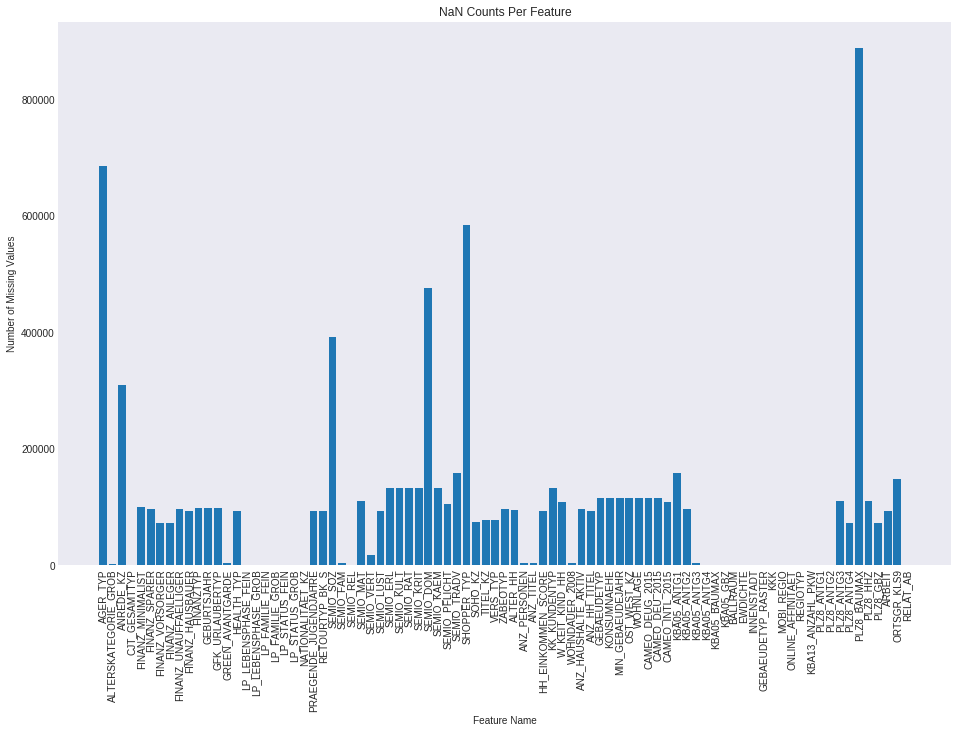

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
na_counts = azdias.isna().sum()

plt.figure(figsize=(16,10))
plt.xticks(np.arange(len(na_counts)), na_counts.index, rotation='vertical')
plt.bar(na_counts.index, na_counts.values)
plt.title('NaN Counts Per Feature')
plt.xlabel('Feature Name')
plt.ylabel('Number of Missing Values')
plt.show();

In [12]:
# Show the top 40 columns with the highest number of missing values
na_counts.sort_values(ascending=False)[:40]

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

In [13]:
# Show the top 40 columns with the lowest number of missing values
na_counts.sort_values(ascending=True)[:40]

ZABEOTYP                     0
SEMIO_TRADV                  0
SEMIO_PFLICHT                0
SEMIO_KAEM                   0
SEMIO_DOM                    0
SEMIO_KRIT                   0
SEMIO_RAT                    0
SEMIO_KULT                   0
SEMIO_ERL                    0
SEMIO_LUST                   0
SEMIO_VERT                   0
SEMIO_MAT                    0
SEMIO_REL                    0
SEMIO_SOZ                    0
SEMIO_FAM                    0
FINANZ_VORSORGER             0
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
FINANZTYP                    0
ALTERSKATEGORIE_GROB      2881
GFK_URLAUBERTYP           4854
LP_STATUS_GROB            4854
LP_STATUS_FEIN            4854
ONLINE_AFFINITAET         4854
RETOURTYP_BK_S            4854
CJT_GESAMTTYP             4854
HH_EINKOMMEN_SCORE       18348
WOHNDAUE

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], inplace=True, axis=1)

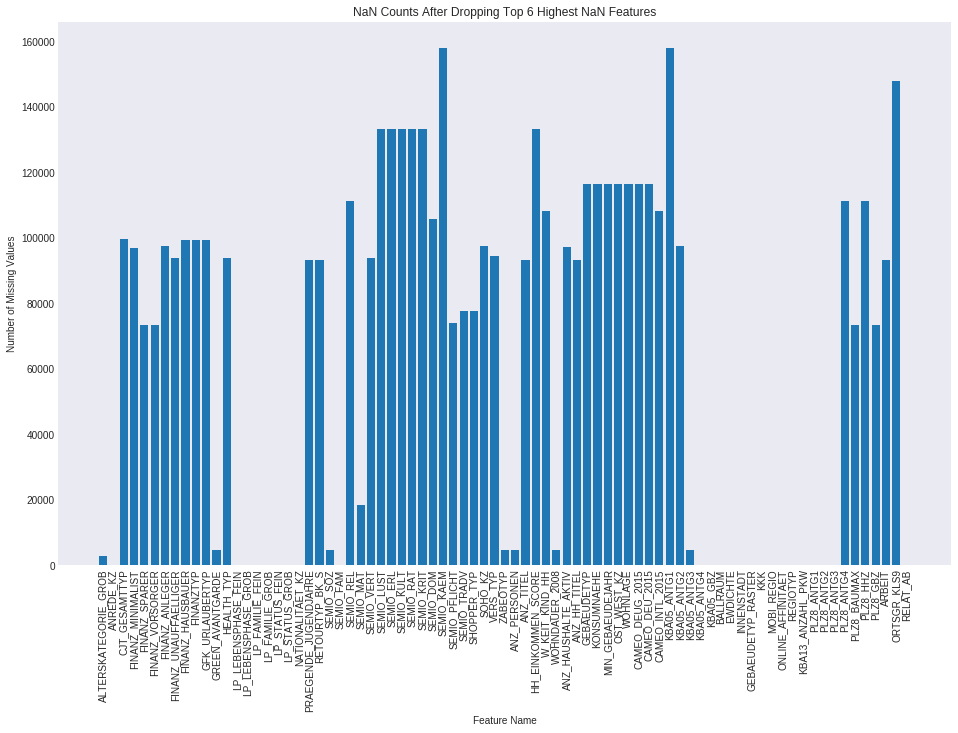

In [15]:
na_counts2 = azdias.isna().sum()

plt.figure(figsize=(16,10))
plt.xticks(np.arange(len(na_counts2)), na_counts2.index, rotation='vertical')
plt.bar(na_counts2.index, na_counts2.values)
plt.title('NaN Counts After Dropping Top 6 Highest NaN Features')
plt.xlabel('Feature Name')
plt.ylabel('Number of Missing Values')
plt.show();

In [16]:
under_100k = (sum(azdias.isna().sum() < 100000)/len(azdias.columns))*100.0
print(f'There is {round(under_100k,2)}% of the features that have under 100,000 missing values.')

There is 72.15% of the features that have under 100,000 missing values.


#### Discussion 1.1.2: Assess Missing Data in Each Column

From the intial graph, I saw there were clear outliers in the number of missing values for each feature. From this observation, I sorted the features in descending order to see the exact number of NaN's for the top missing features. It seemed that most features had less than 160,000 missing values, so I dropped all columns that were above this value. This included: `TITEL_KZ`, `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`, `GEBURTSJAHR`, and `ALTER_HH`. I then plotted a new graph after dropping the outliers, and it seems that most of the data is also below 100,000 missing values (around 72% to be exact). There also do seem to be columns that have matching numbers of missing values, so this could be that certain rows in the dataset are missing values in multiple columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

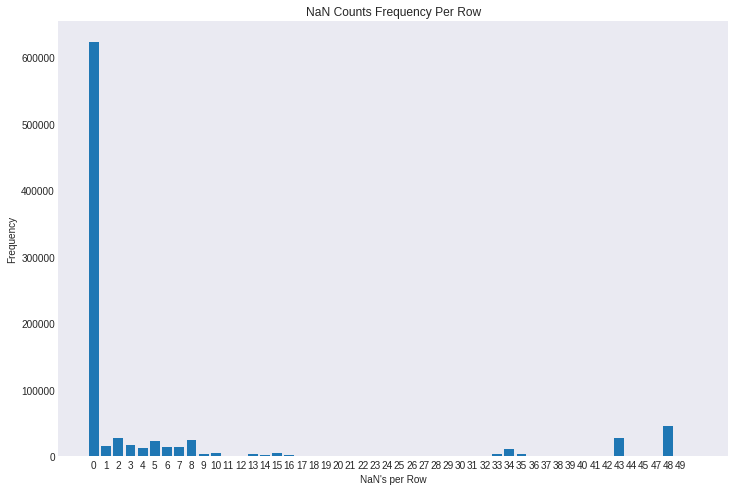

In [56]:
na_row_counts = azdias.isnull().sum(axis=1).value_counts().sort_index()

plt.figure(figsize=(12,8))
plt.xticks(np.arange(len(na_row_counts)), na_row_counts.index)
plt.bar(na_row_counts.index, na_row_counts.values)
plt.title('NaN Counts Frequency Per Row')
plt.xlabel('NaN\'s per Row')
plt.ylabel('Frequency')
plt.show();

In [20]:
# Divide data based on missing features per row (threshold of 13 NaN's)
low_missing = azdias[azdias.isnull().sum(axis=1) < 13]
high_missing = azdias[azdias.isnull().sum(axis=1) >= 13]

In [21]:
print(f'Length of Low Missing Data: {len(low_missing)}')
print(f'Length of High Missing Data: {len(high_missing)}')
# this split was around 88/12 (majority of data in low missing dataframe)

Length of Low Missing Data: 782046
Length of High Missing Data: 109175


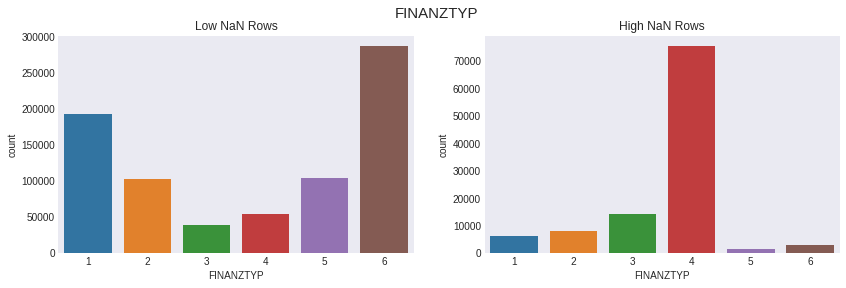

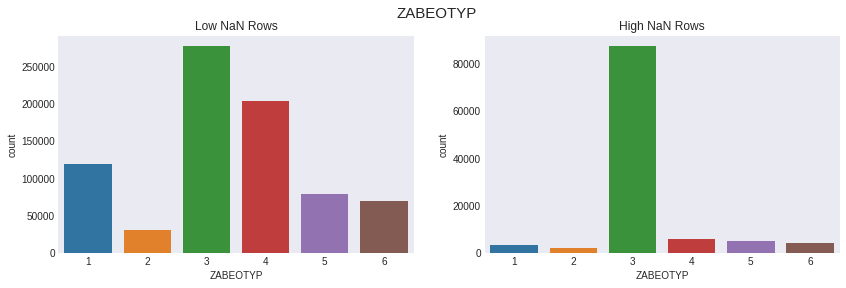

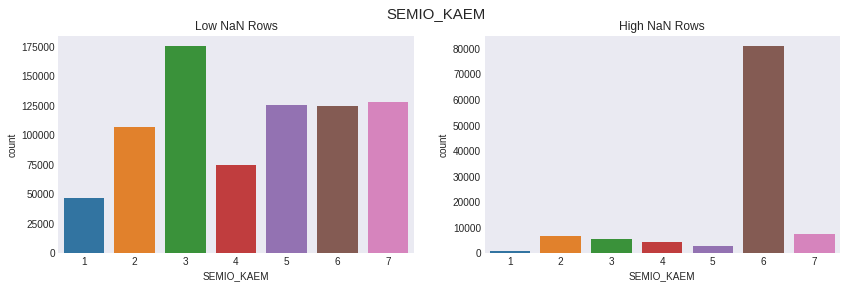

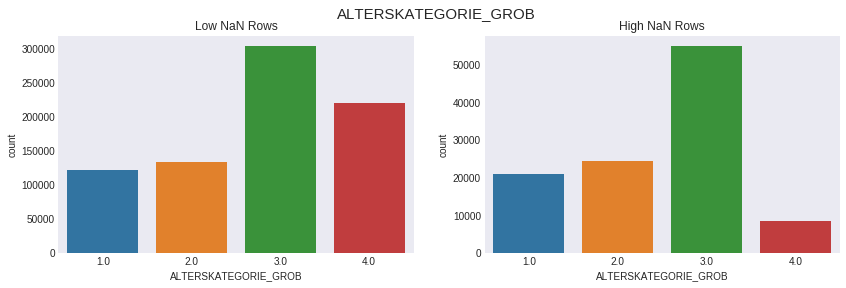

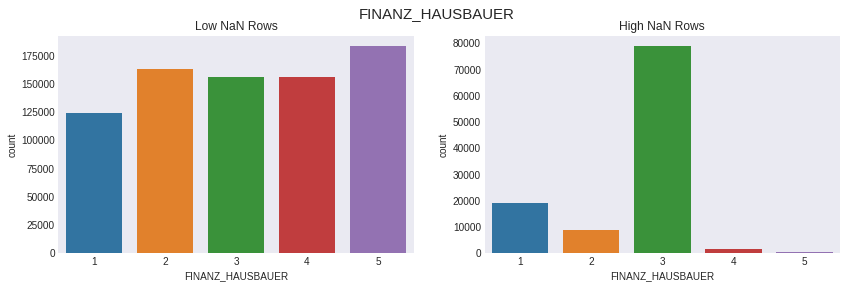

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
feats_compare = ['FINANZTYP', 'ZABEOTYP', 'SEMIO_KAEM', 'ALTERSKATEGORIE_GROB', 'FINANZ_HAUSBAUER']

def compare_plots(column):
    plt.figure(figsize=(14,4))
    ax1 = plt.subplot(1,2,1)
    ax1.title.set_text('Low NaN Rows')
    sns.countplot(x=column, data=low_missing)
    
    ax2 = plt.subplot(1,2,2)
    ax2.title.set_text('High NaN Rows')
    sns.countplot(x=column, data=high_missing)
    
    plt.suptitle(column, fontsize=15)
    return None

for col in feats_compare:
    compare_plots(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the initial count for the number of NaN's per row, it seemed that a majority had 0 or relatively few missing values. Knowing this, I split the data using a threshold of 13 missing values (which resulted in 88% of the data being in the low missing values dataframe). After plotting the low vs high NaN rows above, it seems that the low NaN rows have a much more even spread, while the high NaN rows typically have a large portion of their values centered on a single value.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

In [24]:
# How many features are there of each data type?
feat_info_cleaned = feat_info[feat_info.attribute.isin(low_missing.columns)]
feat_info_cleaned.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
categorical_feat = list(feat_info_cleaned.attribute[feat_info_cleaned.type == 'categorical'])

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
binary = []
multi_level = []
for column in categorical_feat:
    if low_missing[column].nunique() == 2:
        binary.append(column)
    else:
        multi_level.append(column)

print(f'Binary: {binary}')
print(f'Multi-Level: {multi_level}')

Binary: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-Level: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [27]:
for feat in binary:
    print(f'{feat}: {low_missing[feat].unique()}')

ANREDE_KZ: [2 1]
GREEN_AVANTGARDE: [0 1]
SOHO_KZ: [ 1.  0.]
VERS_TYP: [  2.   1.  nan]
OST_WEST_KZ: ['W' 'O']


In [85]:
# Re-encode categorical variable(s) to be kept in the analysis.
data = low_missing.copy() # fix setting error message

data['OST_WEST_KZ'] = data['OST_WEST_KZ'].map({'W':0, 'O':1})

data.drop(multi_level, inplace=True, axis=1)

In [29]:
# Make sure only 5 categorical variables remain after encoding and dropping
feat_info[feat_info.attribute.isin(data.columns)].type.value_counts()

ordinal        49
mixed           6
numeric         6
categorical     5
Name: type, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

I compared the number of unique values for each categorical column to find out wether it was binary or multi-level, storing each column name in is appropriate list. I decided to keep the binary features and dropped the multi-level categorical features. If we want to reduce the dimensions of our data eventually, I dont think creating dummy variables and increasing the number of features will help in that process. I also re-encoded the binary categorical features that did not have a numeric data type (mapping to 0 and 1). I assured that the process worked correctly by checking the number of categorical columns, which is now 5 (binary only).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [56]:
list(feat_info_cleaned.attribute[feat_info.type == 'mixed'])

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

`PRAEGENDE_JUGENDJAHRE` contains 6 decades, so I will map them to 1-6. Movement has two values, so 
I will map them to Avantgarde:0 and Mainstream:1.

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:5, 15:6}
movement_map = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [35]:
data['DECADE'] = data['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
data['MOVEMENT'] = data['PRAEGENDE_JUGENDJAHRE'].map(movement_map)

In [38]:
data[['PRAEGENDE_JUGENDJAHRE', 'DECADE', 'MOVEMENT']].head()

,PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT
1,14.0,5.0,1.0
2,15.0,6.0,0.0
3,8.0,4.0,1.0
4,8.0,4.0,1.0
5,3.0,2.0,1.0


`CAMEO_INTL_2015` has 5 different levels of wealth, so I will map them to 1-5. Similary, it has 5 different levels of life stage so I will map them to 1-5.

In [44]:
data['CAMEO_INTL_2015'].astype(float).unique()

array([ 51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,  41.,
        34.,  55.,  25.,  nan,  23.,  31.,  52.,  35.,  45.,  44.,  32.])

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth_map = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4,
              43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
life_stage_map = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2,
                  43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}

In [50]:
data['WEALTH'] = data['CAMEO_INTL_2015'].astype(float).map(wealth_map)
data['LIFE_STAGE'] = data['CAMEO_INTL_2015'].astype(float).map(life_stage_map)

In [46]:
data[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head()

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0


In [62]:
data['WOHNLAGE'] = data['WOHNLAGE'].astype(int)

In [70]:
data.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], inplace=True, axis=1)

In [71]:
# Make sure only 2 mixed categories remained after dropping others
feat_info[feat_info.attribute.isin(data.columns)].type.value_counts()

ordinal        49
numeric         6
categorical     5
mixed           2
Name: type, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

I dropped `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` since they both related to life stage, which was already covered in the `CAMEO_INTL_2015` feature engineering. Both `CAMEO_INTL_2015` and `PRAEGENDE_JUGENDJAHRE` were dropped after engineering new features from them. I kept `WOHNLAGE` since it related to neighborhood quality and had no missing values (also converted it to integer data type). I kept `PLZ8_BAUMAX` since it had low missing values.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. As a reminder, your data should only be from **the subset with few or no missing values**.

In [72]:
# Dropping columns that were engineered on or no longer in use (multi-level categorical) were all dropped
# in their corresponding sections above. Data is ready to be used.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [4]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Convert missing or unkown values to NaN's
    feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(lambda x : x.strip('][').split(','))
    for idx in range(len(feat_info)):
        missing = feat_info.missing_or_unknown[idx]
        m_vals = [int(val) if (val!='' and val!='XX' and val!='X') else val for val in missing]
        df = df.replace({feat_info.iloc[idx]['attribute']: m_vals}, np.nan)
    
    # Remove selected columns and rows
    df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], inplace=True, axis=1)
    low_missing = df[df.isnull().sum(axis=1) < 13]
    
    # Drop and Re-encode categorical features
    feat_info_cleaned = feat_info[feat_info.attribute.isin(low_missing.columns)]
    categorical_feat = list(feat_info_cleaned.attribute[feat_info_cleaned.type == 'categorical'])
    multi_level = []
    for column in categorical_feat:
        if low_missing[column].nunique() != 2:
            multi_level.append(column)

    data = low_missing.copy() # fix setting error message
    data['OST_WEST_KZ'] = data['OST_WEST_KZ'].map({'W':0, 'O':1})
    data.drop(multi_level, inplace=True, axis=1)
    
    # Engineer Features for mixed type and dropped unused features
    decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:5, 15:6}
    movement_map = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    data['DECADE'] = data['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    data['MOVEMENT'] = data['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
    
    wealth_map = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4,
                  43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    life_stage_map = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2,
                      43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    data['WEALTH'] = data['CAMEO_INTL_2015'].astype(float).map(wealth_map)
    data['LIFE_STAGE'] = data['CAMEO_INTL_2015'].astype(float).map(life_stage_map)
    data['WOHNLAGE'] = data['WOHNLAGE'].astype(int)
    
    data.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], 
              inplace=True, axis=1)
       
    # Return the cleaned dataframe.
    return data

In [5]:
# After building cleaning function, use it and compare to data above to make sure it worked correctly.
geo_data = clean_data(azdias)

In [7]:
geo_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,5.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [9]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
def impute_data(df):
    columns = df.columns
    imputer = Imputer()
    df_imp = imputer.fit_transform(df)

    df_filled = pd.DataFrame(df_imp, columns=columns)
    return df_filled

data_filled = impute_data(geo_data)
print(f'Missing Values: {data_filled.isna().sum().sum()}')
data_filled.head()

Missing Values: 0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,5.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [11]:
# Apply feature scaling to the general population demographics data.
def scale_data(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_final = pd.DataFrame(df_scaled, columns=df.columns)
    return df_final

data_final = scale_data(data_filled)
data_final.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.767309,0.958203,-1.488579,1.539141,-1.045335,1.466874,0.979056,1.327541,-0.530994,1.079040,...,-0.650679,1.432549,0.560345,-0.174490,-0.132811,0.679783,0.755072,0.552582,1.181213,-1.260902
1,0.198792,0.958203,-1.488579,0.866589,-1.771766,-0.569222,0.261642,1.327541,1.883261,1.079040,...,-0.650679,0.399819,0.560345,-0.174490,-0.132811,-0.795300,1.582044,-1.873827,-0.871386,0.761044
2,1.181843,0.958203,0.688223,-0.478515,1.133958,-0.569222,-1.173185,-0.816561,-0.530994,-0.275949,...,-0.650679,-0.632911,0.560345,-1.180194,-1.003765,-0.057759,-0.071899,0.552582,-1.555586,-0.586920
3,0.198792,-1.043621,0.688223,0.194037,0.407527,-1.247921,0.261642,-0.816561,-0.530994,1.079040,...,0.038148,-0.632911,-0.344327,0.831215,0.302665,1.417324,-0.071899,0.552582,0.497013,0.087062
4,-1.767309,0.958203,-0.037377,-1.151067,1.133958,-0.569222,-0.455771,1.327541,-0.530994,1.079040,...,-0.650679,1.432549,1.465017,-1.180194,-1.003765,-0.057759,-1.725843,0.552582,1.181213,0.761044


In [12]:
data_final.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
count,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,...,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05
mean,-7.512775e-16,1.043946e-17,1.469156e-16,3.276300e-17,1.133712e-16,-2.961935e-18,1.293802e-17,9.935202e-17,-8.813119e-18,-1.165512e-16,...,3.646087e-16,-1.094662e-15,1.120447e-16,2.305675e-16,7.735829e-16,-1.693663e-16,8.213464e-17,-1.703558e-15,-4.614440e-16,-1.161042e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.767309e+00,-1.043621e+00,-1.488579e+00,-1.151067e+00,-1.771766e+00,-1.247921e+00,-1.173185e+00,-1.531261e+00,-5.309937e-01,-1.630938e+00,...,-6.506795e-01,-2.698370e+00,-2.153670e+00,-2.185898e+00,-1.874718e+00,-1.532842e+00,-2.552815e+00,-1.873827e+00,-1.555586e+00,-1.260902e+00
25%,-7.842587e-01,-1.043621e+00,-7.629781e-01,-1.151067e+00,-1.045335e+00,-1.247921e+00,-1.173185e+00,-8.165605e-01,-5.309937e-01,-2.759488e-01,...,-6.506795e-01,-6.329106e-01,-3.443267e-01,-1.744895e-01,-5.682882e-01,-7.953005e-01,-8.988712e-01,-1.616314e-15,-8.713865e-01,-1.260902e+00
50%,1.987920e-01,9.582026e-01,-3.737737e-02,1.940370e-01,4.075271e-01,1.094767e-01,-4.557711e-01,-1.018599e-01,-5.309937e-01,-2.759488e-01,...,-6.506795e-01,-9.172484e-16,-3.443267e-01,-1.744895e-01,-1.328115e-01,-5.775886e-02,0.000000e+00,5.525824e-01,4.970133e-01,8.706216e-02
75%,1.181843e+00,9.582026e-01,6.882233e-01,8.665888e-01,1.133958e+00,7.881755e-01,9.790559e-01,6.128408e-01,-5.309937e-01,1.079040e+00,...,7.269756e-01,3.998193e-01,5.603450e-01,8.312147e-01,7.381420e-01,6.797828e-01,7.550723e-01,5.525824e-01,1.181213e+00,7.610442e-01
max,1.181843e+00,9.582026e-01,1.413824e+00,1.539141e+00,1.133958e+00,1.466874e+00,1.696469e+00,1.327541e+00,1.883261e+00,1.079040e+00,...,2.104631e+00,1.432549e+00,1.465017e+00,1.836919e+00,1.609096e+00,1.417324e+00,1.582044e+00,5.525824e-01,1.181213e+00,1.435026e+00


### Discussion 2.1: Apply Feature Scaling

I decided to keep all features and fill them with the mean along the columns (this is the default setting for the Imputer). I also used a Standard Scaler to make sure all features are within the same range (check with *.describe()* to make sure all features had a standard deviation of 1). I also wrote functions that will perform these feature transformations so they can be used later when working with the customer data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [13]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca_full = PCA() # 66 components (all features kept)
pca_half = PCA(n_components=33) # half of features
X_full_pca = pca_full.fit_transform(data_final)
X_half_pca = pca_half.fit_transform(data_final)

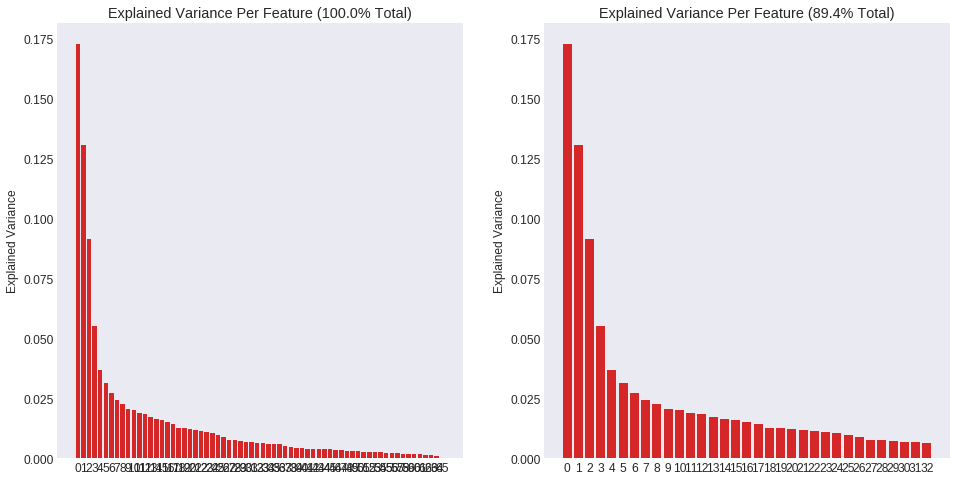

In [14]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(16,8))

def plot_pca(pca, sub):
    total_var = round(sum(pca.explained_variance_ratio_)*100, 2)
    ax = plt.subplot(1, 2, sub)
    ax.title.set_text(f'Explained Variance Per Feature ({total_var}% Total)')
    plt.xticks(np.arange(pca.n_components_))
    plt.bar(np.arange(pca.n_components_), pca.explained_variance_ratio_, color='tab:red')
    plt.ylabel('Explained Variance')
    return None

plot_pca(pca_full, 1)
plot_pca(pca_half, 2)

In [124]:
def optimize_pca(X, n_components):
    var_total = []
    for comp in range(20, n_components):
        pca = PCA(n_components=comp)
        X_pca = pca.fit_transform(X)
        var_total.append(sum(pca.explained_variance_ratio_))
    return var_total

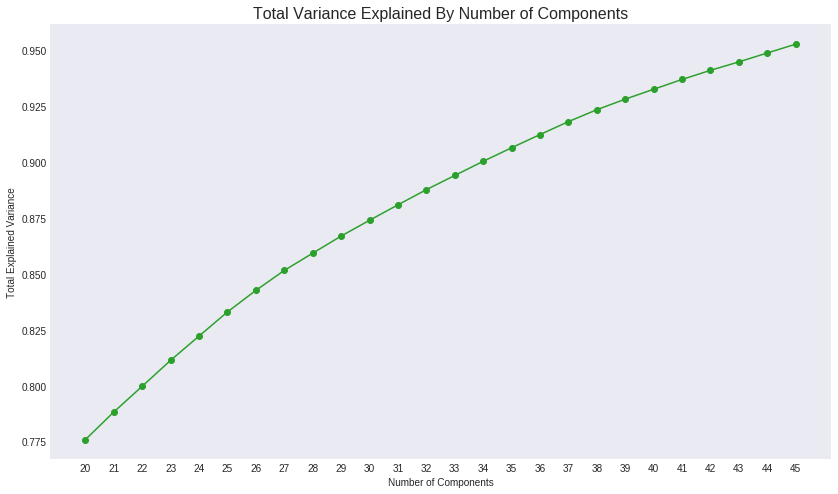

In [125]:
variance = optimize_pca(data_final, 46)
x_range = np.arange(20, 46)
plt.figure(figsize=(14,8))
plt.title('Total Variance Explained By Number of Components', fontsize=16)
plt.xlabel('Number of Components')
plt.ylabel('Total Explained Variance')
plt.xticks(x_range)
plt.plot(x_range, variance, marker='o', color='tab:green')
plt.show();

In [15]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=27)
X_pca = pca.fit_transform(data_final)
print(f'Total Variance for 27 Components: {round(sum(pca.explained_variance_ratio_)*100,2)}%')

Total Variance for 27 Components: 85.16%


### Discussion 2.2: Perform Dimensionality Reduction

I initially graphed two versions of PCA, one with all of the features kept (66) and one with only half of the features (33). We lost around 10% of the total variance when reducing the number of features by 50%. I then created a function that would run PCA on a range of components and graphed these results to see the total variance for each number of components. I wanted to keep around 85% of the variance, so I decided to use 27 components which resulted in 85.16% in total variance being kept. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [26]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def map_weights(pca, df, num):
    weights = {}
    for idx, w in enumerate(pca.components_[num]):
        weights[df.columns[idx]] = w
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)    

first_pc = map_weights(pca, data_final, 0)
first_pc

[('PLZ8_ANTG3', 0.23118874394478692),
 ('PLZ8_ANTG4', 0.22549242974538919),
 ('PLZ8_BAUMAX', 0.22069945239415445),
 ('WEALTH', 0.20502675492542494),
 ('ORTSGR_KLS9', 0.20412259448345621),
 ('EWDICHTE', 0.20169356905571467),
 ('HH_EINKOMMEN_SCORE', 0.1970163889984316),
 ('FINANZ_HAUSBAUER', 0.16418552777200543),
 ('PLZ8_ANTG2', 0.15659645509650788),
 ('KBA05_ANTG4', 0.15386965153076185),
 ('ARBEIT', 0.14615599680880004),
 ('RELAT_AB', 0.13787576260593271),
 ('ANZ_HAUSHALTE_AKTIV', 0.13600275573357262),
 ('KBA05_ANTG3', 0.13277411116354768),
 ('FINANZ_SPARER', 0.11765229307187),
 ('MOVEMENT', 0.098437354472704519),
 ('SEMIO_PFLICHT', 0.088760035744761434),
 ('SEMIO_REL', 0.085859683615465254),
 ('SEMIO_RAT', 0.072746075155093098),
 ('REGIOTYP', 0.069390207097946938),
 ('SEMIO_TRADV', 0.063645315095268926),
 ('SEMIO_MAT', 0.062200000896876474),
 ('SEMIO_FAM', 0.061951516964165815),
 ('DECADE', 0.058138724610366191),
 ('OST_WEST_KZ', 0.05508937489793804),
 ('SEMIO_KULT', 0.0529874887925593

In [27]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_pc = map_weights(pca, data_final, 1)
second_pc

[('ALTERSKATEGORIE_GROB', 0.27182850003100184),
 ('FINANZ_VORSORGER', 0.24340714091370225),
 ('SEMIO_ERL', 0.23753990241899703),
 ('SEMIO_LUST', 0.19037115828448564),
 ('RETOURTYP_BK_S', 0.16358703253151261),
 ('SEMIO_KRIT', 0.11508290451226839),
 ('W_KEIT_KIND_HH', 0.11433162265398922),
 ('SEMIO_KAEM', 0.10672100824745956),
 ('FINANZ_HAUSBAUER', 0.097111197687733367),
 ('FINANZ_MINIMALIST', 0.091919887067509476),
 ('ANREDE_KZ', 0.089059363475718856),
 ('EWDICHTE', 0.069192564829864106),
 ('ORTSGR_KLS9', 0.068093399070071156),
 ('SEMIO_DOM', 0.067105204594884033),
 ('PLZ8_ANTG3', 0.066625493156735868),
 ('WOHNDAUER_2008', 0.065613646622495581),
 ('PLZ8_ANTG4', 0.063626046285250579),
 ('PLZ8_BAUMAX', 0.058849715111871065),
 ('ARBEIT', 0.049958138438244176),
 ('KBA05_ANTG4', 0.049748773908155339),
 ('RELAT_AB', 0.048229909861232836),
 ('WEALTH', 0.047466083055672167),
 ('PLZ8_ANTG2', 0.045856560307082163),
 ('ANZ_HAUSHALTE_AKTIV', 0.045216800714152607),
 ('VERS_TYP', 0.030215322299941935

In [28]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_pc = map_weights(pca, data_final, 2)
third_pc

[('SEMIO_VERT', 0.34753947043512867),
 ('SEMIO_SOZ', 0.26223731226792607),
 ('SEMIO_FAM', 0.24753743772353357),
 ('SEMIO_KULT', 0.232010329600049),
 ('FINANZ_MINIMALIST', 0.16310291181899012),
 ('RETOURTYP_BK_S', 0.10784009939936522),
 ('FINANZ_VORSORGER', 0.10254636657564661),
 ('W_KEIT_KIND_HH', 0.088948162619744531),
 ('ALTERSKATEGORIE_GROB', 0.081724895734629169),
 ('SEMIO_REL', 0.0666683778419358),
 ('SEMIO_LUST', 0.066295167930567292),
 ('GREEN_AVANTGARDE', 0.053680629417261233),
 ('SEMIO_MAT', 0.052063776196510009),
 ('PLZ8_BAUMAX', 0.042764473087416141),
 ('ORTSGR_KLS9', 0.04254554023342498),
 ('EWDICHTE', 0.04166160320858521),
 ('PLZ8_ANTG4', 0.040355111250875791),
 ('PLZ8_ANTG3', 0.039248921647272214),
 ('WOHNDAUER_2008', 0.034395571248757306),
 ('ARBEIT', 0.030490664149725601),
 ('RELAT_AB', 0.027559527808937077),
 ('PLZ8_ANTG2', 0.025748050751986516),
 ('KBA05_ANTG4', 0.021951817923044764),
 ('ANZ_HAUSHALTE_AKTIV', 0.020516092357293139),
 ('WEALTH', 0.019293428500554988),
 

### Discussion 2.3: Interpret Principal Components

For the first principal component:
- Positive Weights: `PLZ8_ANTG3` (number of 6-10 family houses in the PLZ8 region) and `PLZ8_ANTG4` (number of 10+ family houses in the PLZ8 region) have a large correlation, with the increase in one resulting in the increase in the other. 
- Negative Weights: `PLZ8_ANTG1` (number of 1-2 family houses in the PLZ8 region) and `MOBI_REGIO` (movement patterns) have a large correlation, with the increase in one resulting in the increase in the other. 
- An increase in `PLZ8_ANTG3` will lead to a decrease in `MOBI_REGIO` since they are the two largest positive and negative weights values, respectively. 
- `MOBI_REGIO` is the most influential feature, with a weight of -0.24026245859873235.

For the second principal component:
- Positive Weights: `ALTERSKATEGORIE_GROB` (estimated age based on given name analysis) and `FINANZ_VORSORGER` (finance typology) have a large correlation, with the increase in one resulting in the increase in the other. 
- Negative Weights: `FINANZ_SPARER` (finance typology) and `SEMIO_REL` (personality typology) have a large correlation, with the increase in one resulting in the increase in the other. 
- An increase in `ALTERSKATEGORIE_GROB` will lead to a decrease in `SEMIO_REL` since they are the two largest positive and negative weights values, respectively. 
- `ALTERSKATEGORIE_GROB` is the most influential feature, with a weight of +0.27182850003100184.

For the third principal component:
- Positive Weights: `SEMIO_VERT` (personality typology) and `SEMIO_SOZ` (personality typology) have a large correlation, with the increase in one resulting in the increase in the other. 
- Negative Weights: `ANREDE_KZ` (gender) and `SEMIO_KAEM` (personality typology) have a large correlation, with the increase in one resulting in the increase in the other. 
- An increase in `SEMIO_VERT` will lead to a decrease in `ANREDE_KZ` since they are the two largest positive and negative weights values, respectively. 
- `ANREDE_KZ` is the most influential feature, with a weight of -0.36908181776432331.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [32]:
from sklearn.cluster import KMeans

# Run K-Means over a number of different clusters
def kmeans_model(X, clusters):
    start = time()
    model = KMeans(n_clusters=clusters).fit(X)
    score = np.abs(model.score(X))
    end = time()
    print(f'Fit {clusters} clusters in {round(end-start, 2)}s')
    return score

num_clusters = np.arange(2,16) # 2-15 clusters
scores = []
for cluster in num_clusters:
    scores.append(kmeans_model(X_pca, cluster))

Fit 2 clusters in 14.05s
Fit 3 clusters in 50.07s
Fit 4 clusters in 26.01s
Fit 5 clusters in 43.73s
Fit 6 clusters in 51.24s
Fit 7 clusters in 56.14s
Fit 8 clusters in 56.14s
Fit 9 clusters in 73.58s
Fit 10 clusters in 72.87s
Fit 11 clusters in 111.23s
Fit 12 clusters in 108.75s
Fit 13 clusters in 138.94s
Fit 14 clusters in 138.12s
Fit 15 clusters in 171.39s


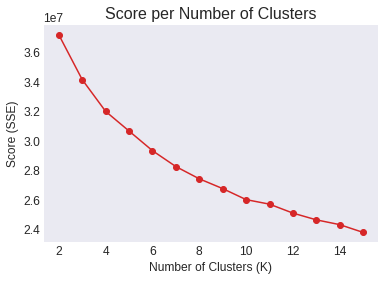

In [34]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_clusters, scores, marker='o', color='tab:red')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Score (SSE)')
plt.title('Score per Number of Clusters', fontsize=16)
plt.show();

In [42]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_15 = KMeans(n_clusters=15).fit(X_pca)
gen_preds = kmeans_15.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

While fitting the KMeans model, I noticed it was taking a long time so I decided to add a timing feature to see how long is was taking per k. As the clusters grew so did the time to train, so I decided to cap k at 15, which took about 3 minutes to fit. From the above graph of the scores for each number of clusters, we don't exactly see an elbow point that determines how many k we should have. But the graph does seem to be flattening out, so I decided to use 15 clusters as my final k.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [43]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [46]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)
customers_imp = impute_data(customers_cleaned)
customers_scale = scale_data(customers_imp)

c_pca = pca.transform(customers_scale)
customer_pred = kmeans_15.predict(c_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups.
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. You can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

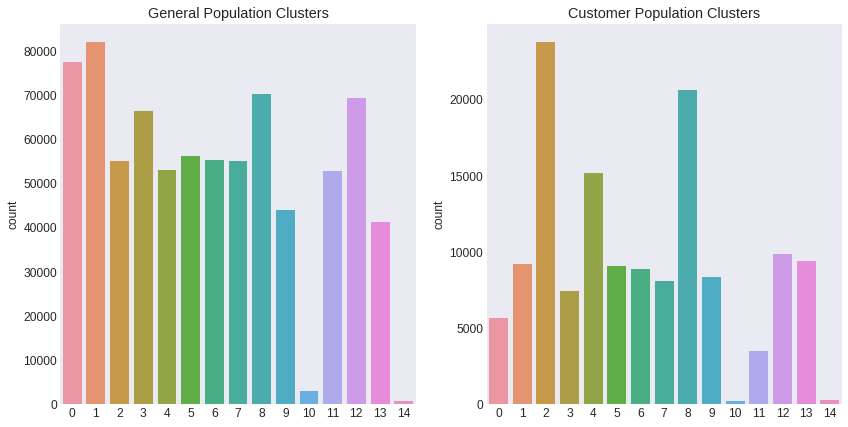

In [59]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,2,1)
ax1.set_title('General Population Clusters')
sns.countplot(gen_preds)

ax2 = plt.subplot(1,2,2)
ax2.set_title('Customer Population Clusters')
sns.countplot(customer_pred)
plt.show();

In [63]:
# Fit scaler in same way as we did before, but outside of the scale_data function so it can be used in
# the next two cells
scaler = StandardScaler()
_ = scaler.fit_transform(data_filled)

In [81]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrep = scaler.inverse_transform(pca.inverse_transform(kmeans_15.cluster_centers_[2]))
cluster_4 = scaler.inverse_transform(pca.inverse_transform(kmeans_15.cluster_centers_[4]))
cluster_8 = scaler.inverse_transform(pca.inverse_transform(kmeans_15.cluster_centers_[8]))

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrep = scaler.inverse_transform(pca.inverse_transform(kmeans_15.cluster_centers_[0]))
cluster_1 = scaler.inverse_transform(pca.inverse_transform(kmeans_15.cluster_centers_[1]))
cluster_11 = scaler.inverse_transform(pca.inverse_transform(kmeans_15.cluster_centers_[11]))

In [83]:
cluster_df = pd.DataFrame(data=overrep, columns=['Cluster 2 (Over/Focus)'], index=data_final.columns)
cluster_df['Cluster 4 (Focus)'] = cluster_4
cluster_df['Cluster 8 (Focus)'] = cluster_8
cluster_df['Cluster 0 (Under/Avoid)'] = underrep
cluster_df['Cluster 1 (Under/Avoid)'] = cluster_1
cluster_df['Cluster 11 (Under/Avoid)'] = cluster_11
cluster_df

,Cluster 2 (Over/Focus),Cluster 4 (Focus),Cluster 8 (Focus),Cluster 0 (Under/Avoid),Cluster 1 (Under/Avoid),Cluster 11 (Under/Avoid)
ALTERSKATEGORIE_GROB,3.277978,2.904780,3.294351,1.653320,1.727224,1.708807
ANREDE_KZ,1.066030,1.083677,1.102789,2.008584,1.983682,0.932869
FINANZ_MINIMALIST,4.861172,3.208114,4.579290,1.156431,2.282227,1.834637
FINANZ_SPARER,1.570619,2.853409,1.746075,4.258313,3.991167,4.416808
FINANZ_VORSORGER,4.233155,3.351944,4.130207,2.236010,2.269657,2.110803
FINANZ_ANLEGER,1.444023,2.529896,2.270349,4.115510,4.424136,3.618546
FINANZ_UNAUFFAELLIGER,2.133957,2.592370,1.911015,3.689830,3.876315,3.807386
FINANZ_HAUSBAUER,1.901299,2.721254,2.013969,4.243005,2.904496,3.715511
GREEN_AVANTGARDE,0.964117,0.063133,0.034649,0.042923,0.176275,0.131968
HEALTH_TYP,2.046486,2.840880,2.326034,2.193601,2.222690,2.280244


### Discussion 3.3: Compare Customer Data to Demographics Data

The main focus of the company should be on customer cluster 2, 4, and 8 which all highly represent the target demographic. They should avoid customer clusters 0, 1, and 11 since these do not represent the target demographic well. We will looked at a few keys feature (gender, wealth, and life stage) but there are many other factors that go into who they should focus their product on. There are just a few key features that I found that I think are a good starting point based on the overrepresented and underrepresented clusters:

To identify which people they should focus on, some features they could concetrate on `ANREDE_KZ` = 1, `WEALTH` = 2 to 3, and `LIFE_STAGE`= 3 to 4. This translates to males in prosperous households who belong to older families / mature couples.

To identify which people they should not focus on, some features they could concetrate on `ANREDE_KZ` = 2, `WEALTH` = 4, and `LIFE_STAGE`= 2 to 3. This translates to females in poorer households who belong to young couples with children.